# Single System with Langraph System with WatsonX

Hello everyone today we are going to learn how o build a Single Agent System with Langraph with WatsonX
We'll start with a basic chatbot introducing key LangGraph concepts along the way.

## Setup

First, install the required packages:

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain_anthropic

# Used for install IBM WatsonX
%pip install python-dotenv  ibm_watson_machine_learning
%pip install "ibm-watsonx-ai" 
%pip install "pydantic>=1.10.0" 
%pip install "langchain>=0.1.52"
%pip install "langchain_ibm>=0.1.7"


Then we setup our API keys:

In [1]:
import os
from dotenv import load_dotenv
import getpass
def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"


(Encouraged) [LangSmith](https://smith.langchain.com/) makes it a lot easier to see what's going on "under the hood."

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

## Part 1: Basic Chatbot with WatsonX and LangGraph
Let's create a simple chatbot using LangGraph with WatsonX. This chatbot will respond directly to user messages.

**What is LangGraph?**
LangGraph is a powerful tool that helps us build complex systems, like chatbots, by connecting different pieces of code together. Think of it like a flowchart, where each step builds on the previous one.

**Creating a StateGraph**
We'll start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". This means we can think of our chatbot as a series of states, and we'll define how it transitions between these states.

**Adding Nodes and Edges**
We'll add `nodes` to represent the different functions our chatbot can perform, like responding to user messages. We'll also add `edges` to specify how the bot should transition between these functions.

Here's the code that sets up the LangGraph State:

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


**Understanding the Code**
Let's break down what's happening in this code:

* We've defined our `State` as a special type of dictionary called a `TypedDict`. This dictionary has a single key: `messages`.
* The `messages` key is special because we're telling LangGraph how to update it. We're using a function called `add_messages` to say, "Hey, when we add new messages, append them to the existing list instead of overwriting it."
* Now our graph knows two important things:
	1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
	2. `messages` will be appended to the current list, rather than directly overwritten.

**Next Steps**
Next, we'll add a "chatbot" node. Nodes represent individual tasks or functions, and they're typically regular Python functions. We'll explore this in more detail in the next section.

**Foundation Models on WatsonX.ai**

WatsonX.ai provides a range of foundation models that can be used for various natural language processing tasks. These models are trained on large datasets and can be fine-tuned for specific tasks.

**List of Available Models**

The available models on WatsonX.ai are listed under the `ModelTypes` class. Here's how you can print the list of available models:

In [4]:
from ibm_watsonx_ai.foundation_models.utils.enums import ModelTypes

print([model.name for model in ModelTypes])

['FLAN_T5_XXL', 'FLAN_UL2', 'MT0_XXL', 'GPT_NEOX', 'MPT_7B_INSTRUCT2', 'STARCODER', 'LLAMA_2_70B_CHAT', 'LLAMA_2_13B_CHAT', 'GRANITE_13B_INSTRUCT', 'GRANITE_13B_CHAT', 'FLAN_T5_XL', 'GRANITE_13B_CHAT_V2', 'GRANITE_13B_INSTRUCT_V2', 'ELYZA_JAPANESE_LLAMA_2_7B_INSTRUCT', 'MIXTRAL_8X7B_INSTRUCT_V01_Q', 'CODELLAMA_34B_INSTRUCT_HF', 'GRANITE_20B_MULTILINGUAL']


This will output a list of available models, including `FLAN_T5_XXL`, `FLAN_UL2`, `MT0_XXL`, and more.

**Choosing a Model**

For this example, let's choose the `ibm/granite-13b-instruct-v2` model.

**Defining the Model Parameters**

We need to define the model parameters for the `ibm/granite-13b-instruct-v2` model. We can do this using the `GenTextParamsMetaNames` class.

In [8]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods

parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 500,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}



**Initializing the WatsonXLLM Class**

Next, we need to initialize the `WatsonxLLM` class, which is a wrapper around the WatsonX.ai models that provides LangChain integration.

In [9]:
from langchain_ibm import WatsonxLLM
model_id = "ibm/granite-13b-instruct-v2"
llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

In [10]:
print(llm.invoke("Who is man's best friend?"))

Man's best friend is his dog. Dogs are man's best friend because they are always there for you, they never judge you, and they love you unconditionally. Dogs are also great companions and can help reduce stress levels. icing on the cake, they are just so cute! 



**Creating the Chatbot Node**

Now that we have the `WatsonxLLM` object, we can create a chatbot node that uses this model to respond to user input.

In [11]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [12]:
graph_builder.add_node("chatbot", chatbot)


This code defines a `chatbot` function that takes the current `State` as input and returns an updated `messages` list. 

The `chatbot` function uses the `llm` object to generate a response to the user's input, and returns a new `messages` list with the response appended to it.

 Finally, we add the `chatbot` node to our graph using the `add_node` method.

In [13]:
graph_builder.set_entry_point("chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [14]:
graph_builder.set_finish_point("chatbot")

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [15]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

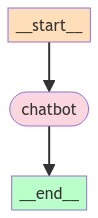

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Testig our Chatbot

In [17]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1])

Assistant: Chain is a class that represents a sequence of values, with an optional starting value and an optional ending value. Chain can be empty or have any length. Chain can be created by calling the constructor with no arguments, which creates an empty chain. Chain can be created by calling the constructor with two arguments, which creates a chain with the starting value at index 0 and the ending value at index 1. Chain can be created by calling the constructor with three arguments, which creates a chain with the starting value at index 0, the ending value at index 1, and the optional starting value at index 2. Chain can be created by calling the constructor with four arguments, which creates a chain with the starting value at index 0, the ending value at index 1, the optional starting value at index 2, and the optional ending value at index 3. Chain can be created by calling the constructor with five arguments, which creates a chain with the starting value at index 0, the ending v